In [1]:
import os
import torch
import torch.nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [2]:
def info_reader(info_path):
    with open(info_path, 'r') as f:
        info_lines = f.read().splitlines()
    info_list = []
    for i in info_lines:
        split = i.split(' ')
        info_list.append((split[0], [int(x) for x in split[1:]]))
    return info_list

In [3]:
def get_full_path(root_path, name):
    return os.path.join(root_path, name+'.jpg')

In [4]:
info_list = info_reader('/home/stevetod/jzy/dataset/PascalVOC/annotations.txt')

In [8]:
import numpy as np
cnt_array = np.zeros(20)
for info in info_list:
    cnt_array[info[1]] += 1

In [10]:
cnt_array / np.sum(cnt_array)

array([0.40369871, 0.03416463, 0.04751875, 0.01432303, 0.0564917 ,
       0.02215856, 0.01503918, 0.03016261, 0.02540231, 0.02312747,
       0.0196731 , 0.05409049, 0.02422277, 0.02481254, 0.03420676,
       0.05754486, 0.02910944, 0.02582357, 0.0312579 , 0.02717162])

In [95]:
class PascalVOCDataset(Dataset):
    def __init__(self, opt):
        self.opt = opt
        self.info_list = info_reader(opt['info_path'])
        self.root_path = opt['root_path']
        if opt['phase'] == 'train':
            self.transform = transforms.Compose([
                transforms.RandomResizedCrop(opt['input_size']),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        elif opt['phase'] == 'val' or opt['phase'] == 'test':
            self.transform = transforms.Compose([
                transforms.Resize(opt['input_size']),
                transforms.CenterCrop(opt['input_size']),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        self.detransform = transforms.Compose([
            UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
            transforms.ToPILImage()])
        self.category_num = opt['category_num']
            
    def __getitem__(self, index):
        info = self.info_list[index]
        img = Image.open(get_full_path(self.root_path, info[0])).convert('RGB')
        target = torch.zeros(self.category_num)
        target[info[1]] = 1
        return self.transform(img), target
    
    def __len__(self):
        return len(self.info_list)

In [102]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [1]:
from data.dataset import PascalVOCDataset

In [2]:
train_opt = {'info_path': '/home/stevetod/jzy/dataset/PascalVOC/train_anno.txt',
             'root_path': '/home/stevetod/jzy/dataset/PascalVOC/JPEGImages/',
             'phase': 'train',
             'input_size': 224,
             'category_num': 20}
ds = PascalVOCDataset(train_opt)

In [3]:
sample, target = ds[2]

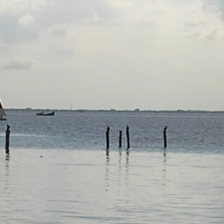

In [4]:
ds.detransform(sample)

In [5]:
target

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])